# Raw read processing and ASV generation using DADA2 

### 1. Install R packages (v3.6.1)

In [1]:
# if (!requireNamespace("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")
# BiocManager::install("dada2")
# BiocManager::install("ShortRead")
# BiocManager::install("Biostrings")
# BiocManager::install("phyloseq")
# install.packages("tidyverse")
# install.packages("stringr")
# install.packages("data.table")
# install.packages("broom")
# install.packages("qualpalr")
# install.packages("viridis")
# install.packages("seqinr")
# install.packages("ape")
# install.packages("phytools")

### 2. Load required R libraries

In [2]:
library(dada2)
library(tidyverse)
library(reshape2)
library(stringr)
library(data.table)
library(broom)
library(qualpalr)
library(viridis)
library(ShortRead)
library(Biostrings)
library(seqinr)
library(phyloseq)
library(ape)
library(phytools)

Loading required package: Rcpp

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths



Attaching package: ‘data.table’


The following objects are masked from ‘package:reshape2’:

    dcast, melt


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: viridisLite

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    cl

### 3. File path setup 

In [3]:
rawpath <- "/Volumes/histolytica/necrobiome/raw"
wdpath <- "~/github/necrobiome/01-raw_data_processing/"
fnFs <- sort(list.files(rawpath, pattern="_R1_001.fastq.gz", full.names=T))
fnRs <- sort(list.files(rawpath, pattern="_R2_001.fastq.gz", full.names=T))
sample.names <- sapply(strsplit(basename(fnFs), "_"), `[`, 1)
message("sample names:")
sample.names

sample names:



[1] "Blank"   "BlankE"  "Negctrl" "NegCtrl" "S01A"    "S02E"    "S04A"   
 [8] "S05E"    "S06A"    "S07E"    "S08A"    "S09E"    "S10A"    "S11E"   
[15] "S12A"    "S13E"    "S14A"    "S15E"    "S16A"    "S17E"    "S18A"   
[22] "S19E"    "S20A"    "S21E"    "S24A"    "S25E"    "S26A"    "S27E"   
[29] "S30A"    "S31E"    "S32A"    "S33E"    "S34A"    "S35E"    "S36A"   
[36] "S37E"    "S48A"    "S49E"    "W03A"    "W04E"    "W06E"    "W07A"   
[43] "W09A"    "W10E"    "W11A"    "W12E"    "W13A"    "W14E"    "W15A"   
[50] "W16E"    "W17A"    "W18E"    "W19A"    "W20E"    "W23A"    "W24E"   
[57] "W25A"    "W26E"    "W27A"    "W28E"    "W29A"    "W30E"    "W31A"   
[64] "W32E"

### 4. Plot quality scores

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



pdf 
  2

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



pdf 
  2

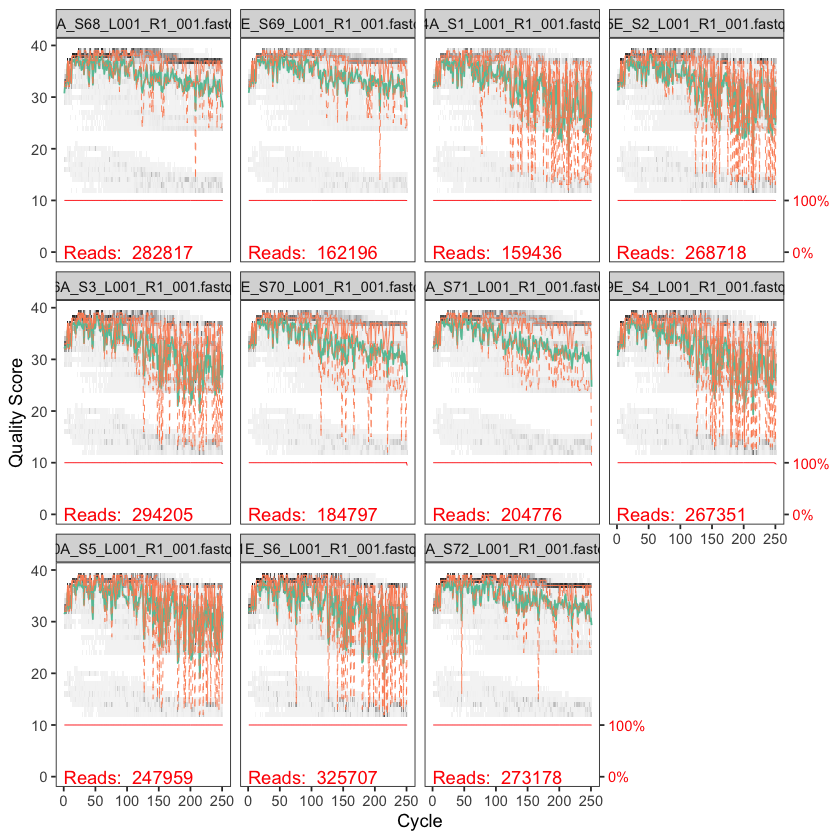

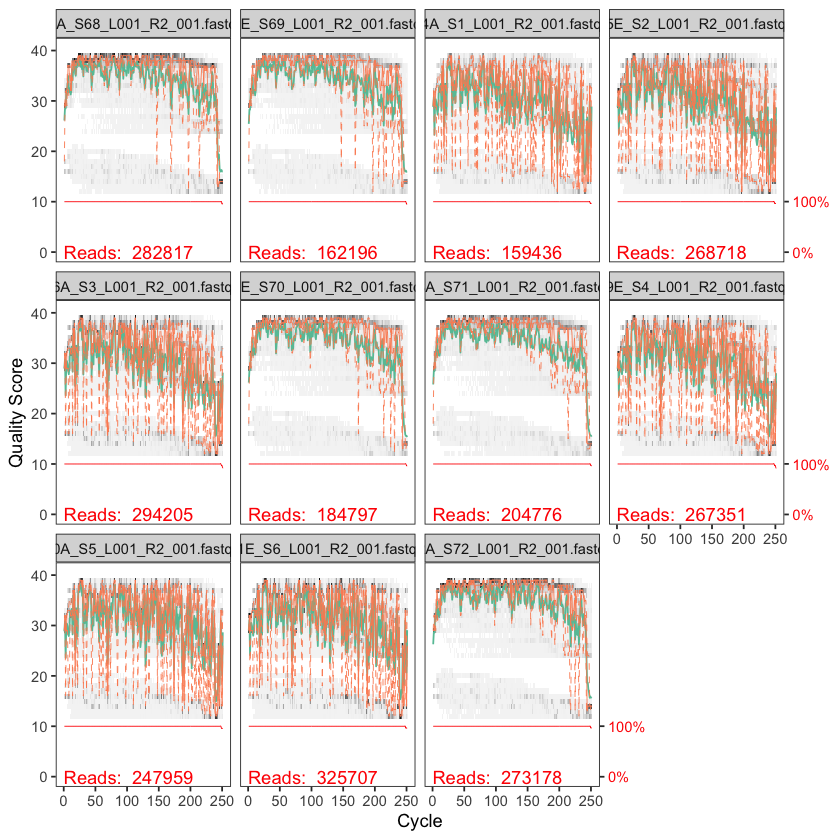

In [4]:
pdf(paste(wdpath, "forward_quality_plot.pdf", sep=""))
fq <- plotQualityProfile(fnFs[5:15])
print(fq)
dev.off()
pdf(paste(wdpath, "reverse_quality_plot.pdf", sep=""))
rq <- plotQualityProfile(fnRs[5:15])
print(rq)
dev.off()
print(fq)
print(rq)

### 5. Preliminary filter out reads with N's

In [5]:
fnFs.filtN <- file.path(rawpath, "filtN", basename(fnFs)) # Put N-filterd files in filtN/ subdirectory
fnRs.filtN <- file.path(rawpath, "filtN", basename(fnRs))
filterAndTrim(fnFs, fnFs.filtN, fnRs, fnRs.filtN, maxN = 0, multithread = TRUE, compress = TRUE)

### 6. Primer removal

In [10]:
cutadapt <- as.character(system("which cutadapt", intern=T))
system("cutadapt --version")
path.cut <- file.path(rawpath, "cutadapt")
if(!dir.exists(path.cut)) dir.create(path.cut)
fnFs.cut <- file.path(path.cut, basename(fnFs))
fnRs.cut <- file.path(path.cut, basename(fnRs))
FWD.RC <- dada2:::rc("GTGYCAGCMGCCGCGGTAA")
REV.RC <- dada2:::rc("GGACTACNVGGGTWTCTAAT")
# Trim FWD and the reverse-complement of REV off of R1 (forward reads)
R1.flags <- paste("-g", "GTGYCAGCMGCCGCGGTAA", "-a", REV.RC) 
# Trim REV and the reverse-complement of FWD off of R2 (reverse reads)
R2.flags <- paste("-G", "GGACTACNVGGGTWTCTAAT", "-A", FWD.RC) 
#Run Cutadapt
system("rm cutadapt.log")
for(i in seq_along(fnFs)) {
  system2(cutadapt, args = c(R1.flags, R2.flags, "-n", 2, "-j 4" # -n 2 required to remove FWD and REV from reads
                             "-o", fnFs.cut[i], "-p", fnRs.cut[i], # output files
                             fnFs.filtN[i], fnRs.filtN[i], "1>cutadapt.log")) # input files
}
# Forward and reverse fastq filenames have the format:
cutFs <- sort(list.files(path.cut, pattern = "_R1_", full.names = TRUE))
cutRs <- sort(list.files(path.cut, pattern = "_R2_", full.names = TRUE))
filtFs <- file.path(path.cut, "filtered", basename(cutFs))
filtRs <- file.path(path.cut, "filtered", basename(cutRs))

### 7. Filter and trim reads

In [11]:
out <- filterAndTrim(cutFs, filtFs, cutRs, filtRs, trimRight=50, minLen = c(150,120),
                     maxN=c(0,0), maxEE=c(2,2), truncQ=c(2,2), rm.phix=TRUE, matchIDs=TRUE,
                     compress=TRUE, multithread=TRUE)
retained <- as.data.frame(out)
retained$percentage_retained <- retained$reads.out/retained$reads.in*100

Creating output directory: /Volumes/histolytica/necrobiome/raw/cutadapt/filtered



### 8. Learn and plot error rates

127332185 total bases in 699324 reads from 3 samples will be used for learning the error rates.
126630385 total bases in 699324 reads from 3 samples will be used for learning the error rates.


pdf 
  2

Warning message:
“Transformation introduced infinite values in continuous y-axis”


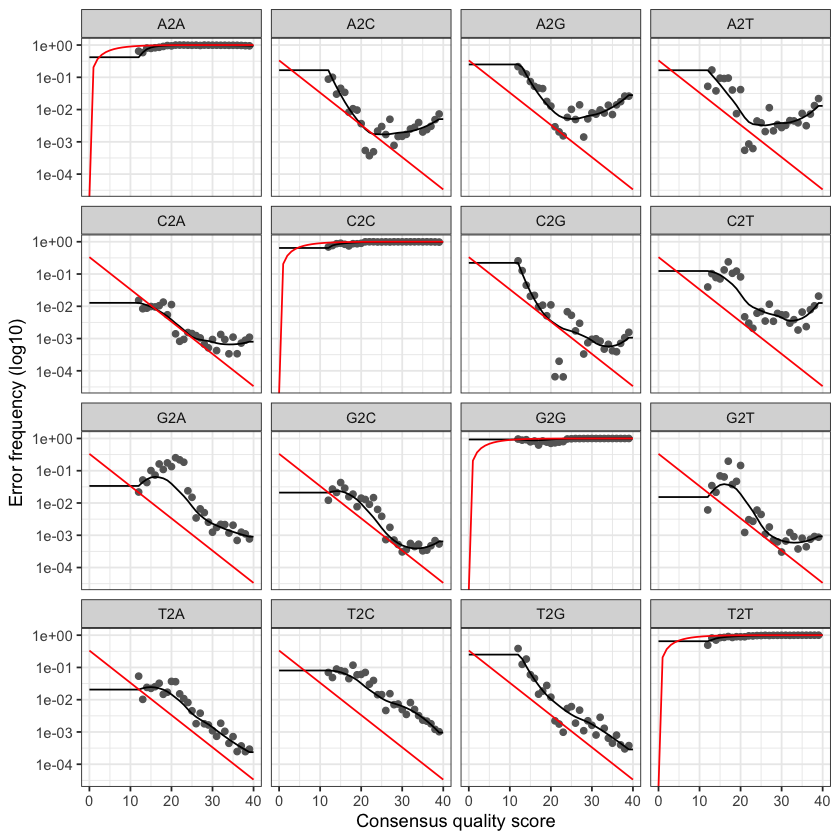

In [12]:
errF <- learnErrors(filtFs, multithread=T)
errF <- learnErrors(filtRs, multithread=T)
pdf(paste(wdpath, "error_plot.pdf", sep=""))
ep <- plotErrors(errF, nominalQ=TRUE) 
dev.off()
print(ep)

### 9. Dereplication

In [ ]:
derepFs <- derepFastq(filtFs, verbose=TRUE)
derepRs <- derepFastq(filtRs, verbose=TRUE)
names(derepFs) <- sample.names
names(derepRs) <- sample.names

### 10. Sample inference

In [ ]:
dadaFs <- dada(derepFs, err=errF, multithread=TRUE)
dadaRs <- dada(derepRs, err=errR, multithread=TRUE)

### 11. Filter out samples with low read counts

In [ ]:
getN <- function(x) sum(getUniques(x))
track <- cbind(sapply(derepFs, getN), sapply(derepRs, getN), sapply(dadaFs, getN), sapply(dadaRs, getN))
samples_to_keep <- track[,4] > 100
samples_to_remove <- names(samples_to_keep)[which(samples_to_keep == FALSE)]
paste("number of samples removed: ", samples_to_remove)

### 12. Merge paired reads

In [ ]:
mergers <- mergePairs(dadaFs[samples_to_keep], derepFs[samples_to_keep], dadaRs[samples_to_keep], derepRs[samples_to_keep], verbose=T, )

### 13. Construct sequence table

In [ ]:
seqtab <- makeSequenceTable(mergers)
dim(seqtab)

### 14. Sequence length distribution post merging

In [ ]:
length.histogram <- as.data.frame(table(nchar(getSequences(seqtab))))
plot(x=length.histogram[,1], y=length.histogram[,2])

### 15. Remove chimeras

In [ ]:
seqtab.nochim <- removeBimeraDenovo(seqtab, method="pooled", multithread=T, verbose=T)
dim(seqtab.nochim)
sum(seqtab.nochim)/sum(seqtab)

### 16. Processing summary

In [ ]:
getN <- function(x) sum(getUniques(x))
track <- cbind(out[samples_to_keep,], sapply(dadaFs[samples_to_keep], getN), sapply(dadaRs[samples_to_keep], getN), sapply(mergers, getN), rowSums(seqtab.nochim))
track <- cbind(track, 100-track[,6]/track[,5]*100, 100-track[,7]/track[,6]*100)
colnames(track) <- c("input", "filtered", "denoisedF", "denoisedR", "merged", "nochimeras", "percent_singletons", "percent_chimeras")
rownames(track) <- sample.names[samples_to_keep]

### 17. Save output

In [ ]:
write.table(data.frame("row_names"=rownames(track),track),"read_retention.16s.txt", row.names=FALSE, quote=F, sep="\t")
write.table(data.frame("row_names"=rownames(seqtab.nochim),seqtab.nochim),"sequence_table.16s.merged.txt", row.names=FALSE, quote=F, sep="\t")
uniquesToFasta(seqtab.nochim, "rep_set.fa")
system("awk '/^>/{print \">ASV\" ++i; next}{print}' < rep_set.fa > rep_set_fix.fa")
system("mv rep_set_fix.fa rep_set.fa")

### 18. Clean up ASV names

In [ ]:
my_otu_table <- t(as.data.frame(seqtab.nochim)) 
ASV.seq <- as.character(unclass(row.names(my_otu_table))) 
ASV.num <- paste0("ASV", seq(ASV.seq), sep='') 
colnames(seqtab.nochim) <- ASV.num 

### 19. Assign taxonomy using VSEARCH and QIIME2

In [ ]:
# get executable paths
qiimepath <- system("conda env list | grep 'qiime' | awk '{print $2}'", intern=T)
qiimepathFix <- paste(qiimepath, "/bin/qiime", sep="")
qiimepathFix
# reference files
BACREF <- "ezbiocloud_qiime_full.fasta"
BACTAX <- "ezbiocloud_id_taxonomy.txt"
# format and run
system(paste(qiimepathFix, "tools import --input-path rep_set.fa --output-path rep_set.qza --type 'FeatureData[Sequence]'")
system("rm -r assigntax")
system(sprintf(paste(qiimepathFix, "feature-classifier classify-consensus-vsearch --i-query rep_set.qza --i-reference-reads %s --i-reference-taxonomy %s --output-dir assigntax"), BACREF, BACTAX)
system("unzip assigntax/classification.qza -d assigntax/")
#get file path for taxonomy file
tempfile <- subset(dir(path="assigntax"), !grepl("classification.qza", dir(path="assigntax/")))
newpath <- paste("assigntax/", tempfile, "/data/taxonomy.tsv", sep="")
#make 7 level taxonomy file -- test this out on tortoise data
system(sprintf("awk '{print $2}' %s | sed '1d' > taxonomy_strings.txt", newpath))
system(sprintf("awk '{print $1}' %s | sed '1d' > asv_ids.txt", newpath))
system("python fix_taxonomy_L7.py taxonomy_strings.txt > fix_string.txt")
system("paste asv_ids.txt fix_string.txt > taxonomy_L7.txt")
system("rm taxonomy_strings.txt fix_string.txt asv_ids.txt")

### 20. Combine sequence and taxonomy tables

In [ ]:
#taxa will be the rows, columns will be samples, followed by each rank of taxonomy assignment, from rank1 (domain-level) to rank7/8 (species-level), followed by accession (if applicable)
#first check if the row names of the taxonomy table match the column headers of the sequence table
taxa <- read.table(newpath, header=T, sep="\t", row.names=1)
length(which(row.names(taxa) %in% colnames(seqtab.nosingletons.nochim)))
dim(taxa)
dim(seqtab.nosingletons.nochim)
#the number of taxa from the last three commands should match

#now ensure that the taxa in the tables are in the same order #this should be true if you haven't reordered one or the other of these matrices inadvertently
order.col <- row.names(taxa)
seqtab.nosingletons.nochim <- seqtab.nosingletons.nochim[,order.col]
row.names(taxa) == colnames(seqtab.nosingletons.nochim) #IMPORTANT: only proceed if this evaluation is true for every element. if it isn't you'll need to re-order your data. I'd suggest sorting both matrices by their rows after transposing the sequence table.

#as long as the ordering of taxa is the same, you can combine like this (note you need to transpose the sequence table so that the taxa are in the rows)
sequence_taxonomy_table <- cbind(t(seqtab.nosingletons.nochim), taxa)

#now write to file
write.table(data.frame("row_names"=rownames(sequence_taxonomy_table),sequence_taxonomy_table),"sequence_taxonomy_table.16s.merged.txt", row.names=FALSE, quote=F, sep="\t")


### 21. Filter out unwanted taxonomic groups

In [ ]:
system("grep -v -E 'Unassigned|Bacteria;unknown' sequence_taxonomy_table.16s.merged.txt | awk '{print $1}' | grep 'A' > wanted.ids")
wanted <- read.table("wanted.ids", header=F)
seqtab.filtered <- seqtab.nosingletons.nochim[, which(colnames(seqtab.nosingletons.nochim) %in% wanted$V1)]
write.table(data.frame("row_names"=rownames(seqtab.filtered),seqtab.filtered),"sequence_table.16s.filtered.txt", row.names=FALSE, quote=F, sep="\t")

### 22. Generate representative sequence tree

In [ ]:
system("seqtk subseq rep_set.fa wanted.ids > rep_set.filt.fa")
system("mafft --auto rep_set.filt.fa > rep_set.filt.align.fa")
system("fasttree -nt rep_set.filt.align.fa > rep_set.filt.tre")
#midpoint root tree
tre <- read.tree("rep_set.filt.tre")
root <- midpoint.root(tre)
write.tree(root, "rep_set.root.tre")